In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

In [17]:
import glob
DEBUG =False

# file_list = glob.glob('data/FBK_Preproduccion/337/SET1/DC/C2--OV7--00**')
# file_list = glob.glob('/media/rodrigoa/Andresito/FBK_Preproduccion/337/SET1/DC/C2--OV7--00**')
# file_list = glob.glob('/media/rodrigoa/Andresito/FBK_Preproduccion/225/SET1/DC/C2--OV7--**')
file_list = glob.glob('/media/rodrigoa/Andresito/FBK_Preproduccion/Mal amplificados/337/SET1/DC/C3--OV45--00**')
file_list[:3]

['/media/rodrigoa/Andresito/FBK_Preproduccion/Mal amplificados/337/SET1/DC/C3--OV45--00162.txt',
 '/media/rodrigoa/Andresito/FBK_Preproduccion/Mal amplificados/337/SET1/DC/C3--OV45--00000.txt',
 '/media/rodrigoa/Andresito/FBK_Preproduccion/Mal amplificados/337/SET1/DC/C3--OV45--00001.txt']

In [18]:
#try reading the first file

file1_path = file_list[0]
HEADER=3
N_SEGMENTs=50
PRETRIGGER=5e-6 #in s

def DC_get_times_file(file_path):
    decimal_numbers = []
    with open(file_path, 'r') as file:
        lines = file.readlines()[HEADER:N_SEGMENTs+HEADER]
        for line in lines:
            words = line.split(',')
            last_word = words[-1]
            decimal_numbers.append(float(last_word))
    # if DEBUG:
    #     print(decimal_numbers)
    windows_times = np.array(decimal_numbers)
    windows_times += PRETRIGGER;
    return np.array(windows_times)

def DC_get_ADCs_file(file_path):
    ADCs=np.loadtxt(file_path, delimiter=',', skiprows=54)
    period=ADCs[1,0]-ADCs[0,0]
    ADCs=ADCs[:,1]

    LEN_SEG=int(ADCs.shape[0]/N_SEGMENTs)
    ADCs=ADCs.reshape((N_SEGMENTs,LEN_SEG))
    return ADCs,period

def DC_read_file(file_path,polarity=-1):
    times=DC_get_times_file(file_path)
    ADCs,period=DC_get_ADCs_file(file_path)
    ADCs=ADCs*polarity
    
    return times, ADCs,period

import scipy.signal as signal
from scipy.ndimage import gaussian_filter1d

def smooth_and_find_peaks(ADCs,period, threshold=0.0002, PED_RANGE=50):
    # FILTERING
    smoothed_ADCs = gaussian_filter1d(ADCs, sigma=4, mode='reflect', axis=1)
    
    # REMOVE PEDESTAL (baseline=0)    
    smoothed_ADCs = (smoothed_ADCs.T - np.mean(smoothed_ADCs[:, :PED_RANGE], axis=1).T).T

    # FIND PEAKS
    peaks = []
    peak_values = []  # New list to store ADC values at each peak
    for row in smoothed_ADCs:
        peak_indices, _ = signal.find_peaks(row, width=50, height=threshold)
        peaks.append(peak_indices*period)
        peak_values.append(row[peak_indices])  # Store ADC values at each peak

    return peaks, peak_values, smoothed_ADCs

DEBUG=False

if DEBUG:
    times, ADCs,period=DC_read_file(file1_path)
    peaks,  peak_values, smoothed_ADCs = smooth_and_find_peaks(ADCs,period=period)
    plt.hist(np.max(smoothed_ADCs,axis=1),bins=100);

    for i in range(10):
        plt.figure()
        plt.plot(np.arange(len(smoothed_ADCs[i]))*period,smoothed_ADCs[i])
        plt.plot(peaks[i], peak_values[i], "x")

In [19]:
def DC_process_file(file_path):
    #read the file
    times, ADCs,period=DC_read_file(file_path)

    #find peaks
    peaks,  peak_values, _ = smooth_and_find_peaks(ADCs,period=period)

    return times, peaks, peak_values
    # return times,mean_ADCs,period

In [20]:
DELTA_TIMES       =[]
PEAK_VALUES =[]
# for f_path in [file_list[0]]:
for f_path in file_list:
    times, peak_times, peak_values, =DC_process_file(f_path);
    
    #add segment time to peak time
    times=(ak.Array(peak_times)+ak.Array(times))
    # flatten
    times=ak.flatten(times)

    #refer to previous segment
    times_aux =times[1:]-times[:-1]

    # also flatten peak values
    peak_values=ak.flatten(ak.Array(peak_values))
    
    #remove 1st element of each segment, t=0    
    peak_values=peak_values[1:]
    
    #add to list
    DELTA_TIMES.append(times_aux)
    PEAK_VALUES.append(peak_values)

#finally flatten
DELTA_TIMES = np.array(ak.flatten(ak.Array(DELTA_TIMES)))
PEAK_VALUES = np.array(ak.flatten(ak.Array(PEAK_VALUES)))

[]

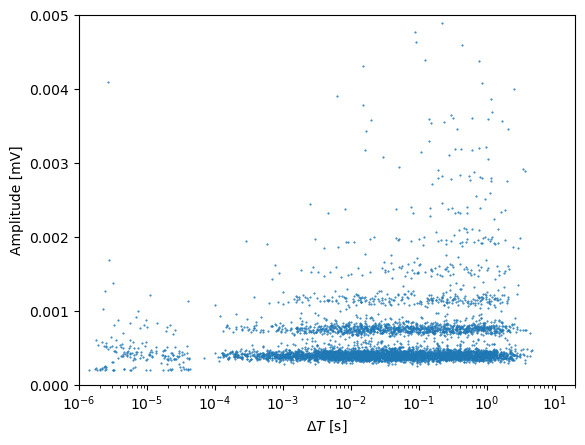

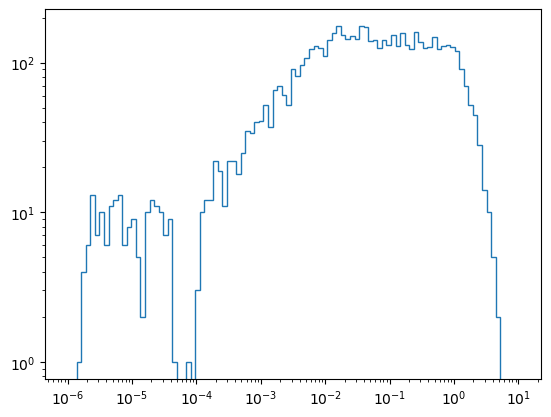

In [21]:

plt.plot(DELTA_TIMES,PEAK_VALUES,'.',markersize=1)
plt.semilogx()
plt.xlim(1e-6,20)
plt.ylim(0,0.0050)

plt.ylabel('Amplitude [mV]')
plt.xlabel('$\Delta T$ [s]')

plt.figure()
bins=np.logspace(-6,1,100)

plt.hist(DELTA_TIMES,bins=bins,histtype='step',log=True);
plt.semilogx()

[]

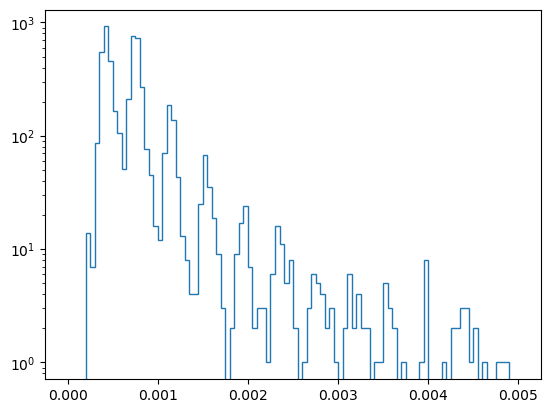

In [13]:
plt.hist(PEAK_VALUES,bins=100,range=[0,0.005],histtype='step');
plt.semilogy()